In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels

In [2]:
!wget https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/refs/heads/master/PJME_hourly.csv PJME_hourly.csv

--2025-06-24 07:19:21--  https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/refs/heads/master/PJME_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070265 (3.9M) [text/plain]
Saving to: ‘PJME_hourly.csv’

PJME_hourly.csv     100%[===================>]   3.88M  --.-KB/s    in 0.04s   

2025-06-24 07:19:21 (104 MB/s) - ‘PJME_hourly.csv’ saved [4070265/4070265]

--2025-06-24 07:19:21--  http://pjme_hourly.csv/
Resolving pjme_hourly.csv (pjme_hourly.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘pjme_hourly.csv’
FINISHED --2025-06-24 07:19:21--
Total wall clock time: 0.3s
Downloaded: 1 files, 3.9M in 0.04s (104 MB/s)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb

In [4]:
# Load dataset
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
# Sort by date
df = df.sort_index()
# Example: Assume 'PJME_MW' is the energy consumption column
df = df[['PJME_MW']]

PJME_MW    0
dtype: int64


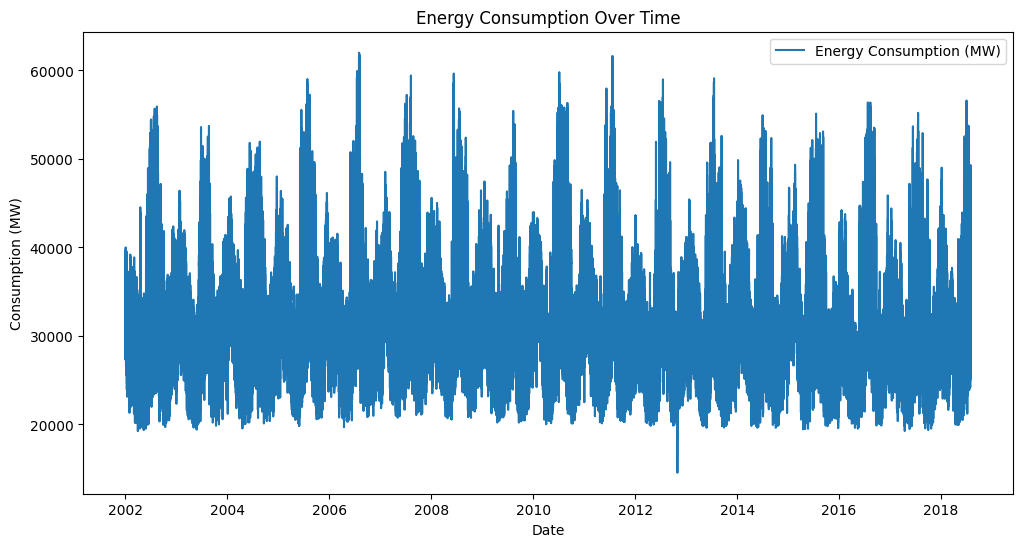

In [5]:
# Check for missing values
print(df.isnull().sum())
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['PJME_MW'], label='Energy Consumption (MW)')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

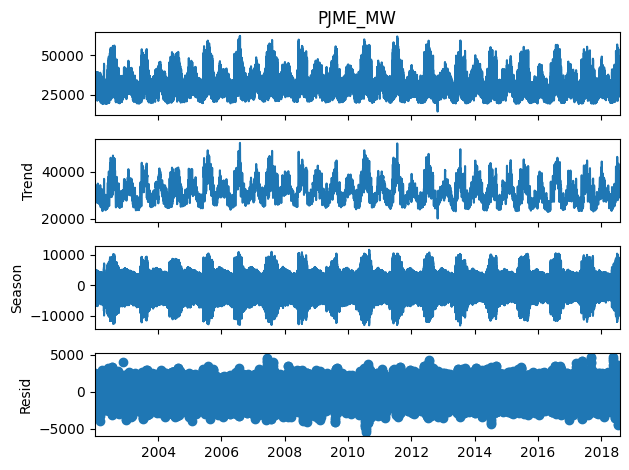

In [6]:
# Perform STL decomposition (adjust period based on data, e.g., 24 for hourly, 365 for daily)
stl = STL(df['PJME_MW'], period=24)
result = stl.fit()
# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid
# Plot decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

In [7]:
df['trend'] = trend
df['seasonal'] = seasonal
df['residual'] = residual

In [8]:
# Create lag features (e.g., last 3 time steps)
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)

In [9]:
# Rolling mean and std (e.g., 24-hour window for hourly data)
df['rolling_mean_24'] = df['PJME_MW'].rolling(window=24).mean()
df['rolling_std_24'] = df['PJME_MW'].rolling(window=24).std()

In [10]:
# Simple moving average (e.g., 24-hour MA)
df['ma_24'] = df['PJME_MW'].rolling(window=24).mean()

In [11]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek

In [12]:
df = df.dropna()

In [13]:
# Target: Energy consumption (PJME_MW)
y = df['PJME_MW']
# Features: All engineered features
X = df.drop('PJME_MW', axis=1)

In [14]:
# Example: Last 20% of data for testing
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [15]:
# Initialize XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
y_pred = model.predict(X_test)

In [17]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'MAPE: {mape:.2f}%')
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

MAPE: 0.87%
RMSE: 344.75


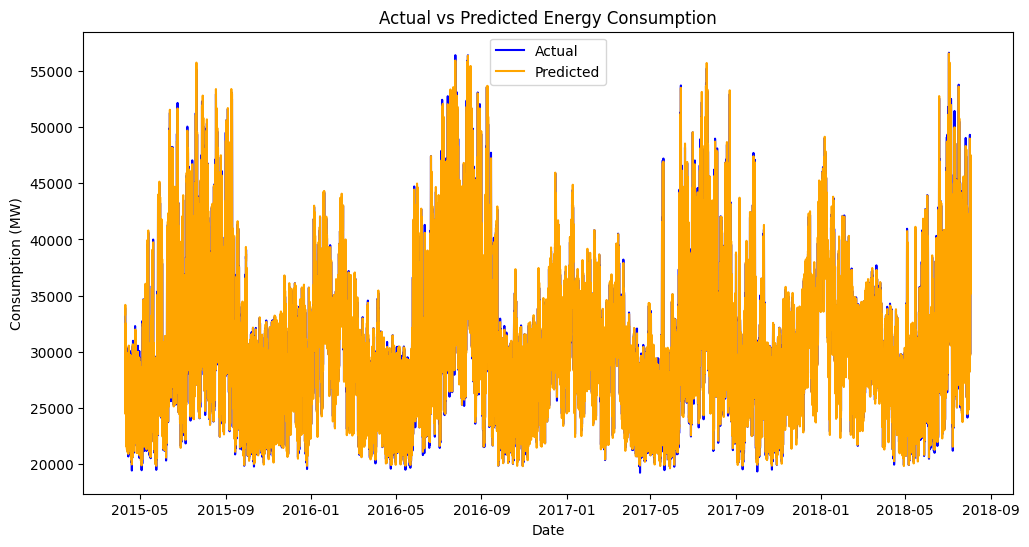

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.show()

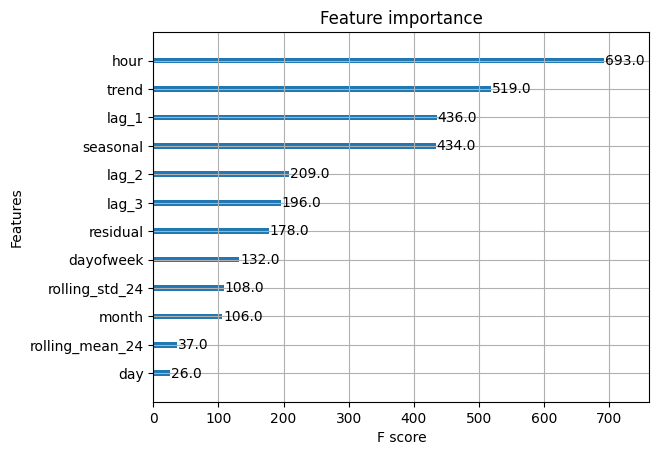

In [19]:
xgb.plot_importance(model)
plt.show()

In [20]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
# Add more lags (e.g., up to 48 hours for hourly data)
for lag in range(1, 49):
    df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)

In [22]:
# Add rolling min and max
df['rolling_min_24'] = df['PJME_MW'].rolling(window=24).min()
df['rolling_max_24'] = df['PJME_MW'].rolling(window=24).max()
# Try a larger window (e.g., 168 hours = 1 week)
df['rolling_mean_168'] = df['PJME_MW'].rolling(window=168).mean()

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df.index.min(), end=df.index.max())
df['is_holiday'] = df.index.isin(holidays).astype(int)

In [24]:
# Add Fourier terms for daily periodicity (24-hour cycle)
for k in range(1, 3):  # First two Fourier terms
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df.index.hour / 24)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df.index.hour / 24)

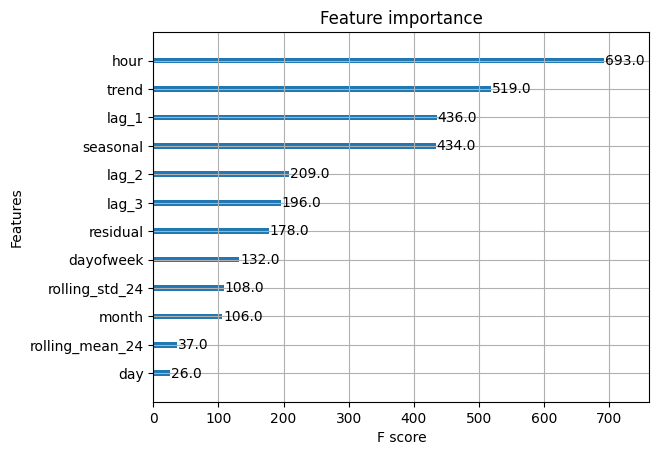

In [25]:
xgb.plot_importance(model)
plt.show()

### Grid Search

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],      # 2 values
    'max_depth': [3, 5],             # 2 values
    'learning_rate': [0.05],         # Fixed
    'subsample': [0.8],              # Fixed
    'colsample_bytree': [0.8]        # Fixed
}

# param_grid = {
#     'n_estimators': [100, 200],#, 300],
#     'max_depth': [3, 5,],# 7],
#     'learning_rate': [0.01, 0.05],#, 0.1],
#     'subsample': [0.7, 0.8],#, 1.0],
#     'colsample_bytree': [0.7, 0.8]#, 1.0]
# }

# Initialize XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Use best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE: 353.7836798513566


In [31]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')

MAPE: 0.86%
RMSE: 340.40


### Trying Randomized Search

In [32]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.05],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8]},
                   scoring='neg_mean_squared_error', verbose=1)

In [33]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    lambda_=1.0,  # L2 regularization
    alpha=0.5     # L1 regularization
)

In [34]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:6292.39859
[1]	validation_0-rmse:5994.87958
[2]	validation_0-rmse:5710.96773
[3]	validation_0-rmse:5440.63031
[4]	validation_0-rmse:5184.78077
[5]	validation_0-rmse:4940.75298
[6]	validation_0-rmse:4711.06938
[7]	validation_0-rmse:4491.71958
[8]	validation_0-rmse:4282.99889
[9]	validation_0-rmse:4084.42476
[10]	validation_0-rmse:3895.48904
[11]	validation_0-rmse:3714.54073


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:3545.24417
[13]	validation_0-rmse:3384.53786
[14]	validation_0-rmse:3229.59323
[15]	validation_0-rmse:3083.43244
[16]	validation_0-rmse:2944.07724
[17]	validation_0-rmse:2811.99211
[18]	validation_0-rmse:2687.34748
[19]	validation_0-rmse:2567.38995
[20]	validation_0-rmse:2453.88017
[21]	validation_0-rmse:2347.87936
[22]	validation_0-rmse:2245.63808
[23]	validation_0-rmse:2148.22912
[24]	validation_0-rmse:2056.80138
[25]	validation_0-rmse:1968.08969
[26]	validation_0-rmse:1884.76552
[27]	validation_0-rmse:1807.23429
[28]	validation_0-rmse:1732.61322
[29]	validation_0-rmse:1663.32393
[30]	validation_0-rmse:1596.00845
[31]	validation_0-rmse:1532.39425
[32]	validation_0-rmse:1471.55141
[33]	validation_0-rmse:1414.64791
[34]	validation_0-rmse:1359.99139
[35]	validation_0-rmse:1309.28640
[36]	validation_0-rmse:1260.93132
[37]	validation_0-rmse:1215.92226
[38]	validation_0-rmse:1172.25585
[39]	validation_0-rmse:1131.87557
[40]	validation_0-rmse:1092.98692
[41]	validatio

XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda_=1.0, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [35]:
mape_scores = []
rmse_scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model.fit(X_t, y_t)
    y_v_pred = model.predict(X_v)
    mape_scores.append(mean_absolute_percentage_error(y_v, y_v_pred) * 100)
    rmse_scores.append(np.sqrt(mean_squared_error(y_v, y_v_pred)))
print(f'Average CV MAPE: {np.mean(mape_scores):.2f}%')
print(f'Average CV RMSE: {np.mean(rmse_scores):.2f}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, Use

Average CV MAPE: 0.77%
Average CV RMSE: 351.92


In [36]:
df.describe()

,PJME_MW,trend,seasonal,residual,lag_1,lag_2,lag_3,rolling_mean_24,rolling_std_24,ma_24,...,lag_47,lag_48,rolling_min_24,rolling_max_24,rolling_mean_168,is_holiday,sin_1,cos_1,sin_2,cos_2
count,145343.000000,145343.000000,145343.000000,145343.000000,145342.000000,145341.000000,145340.000000,145343.000000,145343.000000,145343.000000,...,145296.000000,145295.000000,145320.000000,145320.000000,145176.000000,145343.000000,145343.000000,1.453430e+05,145343.000000,1.453430e+05
mean,32080.380995,32080.263350,0.080494,0.037151,32080.357564,32080.313394,32080.248225,32079.600062,4244.779373,32079.600062,...,32077.933591,32077.942317,25235.506400,37668.611141,32077.071138,0.001128,-0.000110,-1.303745e-04,-0.000165,-2.752111e-05
std,6464.440650,4641.617375,4269.217475,794.515423,6464.456717,6464.457024,6464.431520,4684.414222,1637.150030,4684.414222,...,6462.929931,6462.951316,3570.271791,6367.610442,3983.132038,0.033572,0.707119,7.070995e-01,0.707058,7.071603e-01
min,14544.000000,20024.398037,-13135.038334,-5494.467296,14544.000000,14544.000000,14544.000000,19307.416667,1040.007859,19307.416667,...,14544.000000,14544.000000,14544.000000,24817.000000,24334.416667,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
25%,27573.000000,28621.986003,-3518.569992,-440.313038,27573.000000,27573.000000,27573.000000,28607.666667,3108.470437,28607.666667,...,27571.000000,27571.000000,22336.000000,32867.000000,28754.379464,0.000000,-0.707107,-7.071068e-01,-0.866025,-8.660254e-01
50%,31421.000000,31326.810716,1077.847121,-15.341922,31421.000000,31421.000000,31421.000000,31328.333333,3742.036533,31328.333333,...,31420.000000,31420.000000,24611.000000,36382.000000,31464.842262,0.000000,0.000000,-1.836970e-16,0.000000,-1.836970e-16
75%,35650.500000,34962.313798,2908.986649,446.965949,35650.750000,35650.000000,35650.000000,34971.166667,5092.655684,34971.166667,...,35646.000000,35646.000000,27537.500000,41280.000000,34803.959821,0.000000,0.707107,7.071068e-01,0.500000,8.660254e-01
max,62009.000000,52209.941057,11579.637932,4719.680155,62009.000000,62009.000000,62009.000000,52261.416667,11014.844383,52261.416667,...,62009.000000,62009.000000,41760.000000,62009.000000,47230.702381,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00


### Model Comparison: With and Without Seasonal Decomposition

In [37]:
# Model WITHOUT seasonal decomposition
# Prepare data without seasonal components
y_no_decomp = df['PJME_MW']
X_no_decomp = df.drop(['PJME_MW', 'trend', 'seasonal', 'residual'], axis=1)

# Train-test split for non-decomposed model
X_train_no_decomp, X_test_no_decomp = X_no_decomp.iloc[:train_size], X_no_decomp.iloc[train_size:]
y_train_no_decomp, y_test_no_decomp = y_no_decomp.iloc[:train_size], y_no_decomp.iloc[train_size:]

In [38]:
# Train model without seasonal decomposition
model_no_decomp = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    lambda_=1.0,
    alpha=0.5
)
model_no_decomp.fit(X_train_no_decomp, y_train_no_decomp)

# Predictions without seasonal decomposition
y_pred_no_decomp = model_no_decomp.predict(X_test_no_decomp)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


In [39]:
# Train model WITH seasonal decomposition (using existing features)
model_with_decomp = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    lambda_=1.0,
    alpha=0.5
)
model_with_decomp.fit(X_train, y_train)
y_pred_with_decomp = model_with_decomp.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


In [40]:
# Calculate metrics for both models
mape_no_decomp = mean_absolute_percentage_error(y_test, y_pred_no_decomp) * 100
rmse_no_decomp = np.sqrt(mean_squared_error(y_test, y_pred_no_decomp))

mape_with_decomp = mean_absolute_percentage_error(y_test, y_pred_with_decomp) * 100
rmse_with_decomp = np.sqrt(mean_squared_error(y_test, y_pred_with_decomp))

print("=== MODEL COMPARISON ===")
print(f"WITHOUT Seasonal Decomposition:")
print(f"  MAPE: {mape_no_decomp:.2f}%")
print(f"  RMSE: {rmse_no_decomp:.2f}")
print(f"\nWITH Seasonal Decomposition:")
print(f"  MAPE: {mape_with_decomp:.2f}%")
print(f"  RMSE: {rmse_with_decomp:.2f}")
print(f"\nImprovement with Seasonal Decomposition:")
print(f"  MAPE: {mape_no_decomp - mape_with_decomp:.2f}% points")
print(f"  RMSE: {rmse_no_decomp - rmse_with_decomp:.2f}")

=== MODEL COMPARISON ===
WITHOUT Seasonal Decomposition:
  MAPE: 1.02%
  RMSE: 419.69

WITH Seasonal Decomposition:
  MAPE: 0.86%
  RMSE: 341.55

Improvement with Seasonal Decomposition:
  MAPE: 0.17% points
  RMSE: 78.14


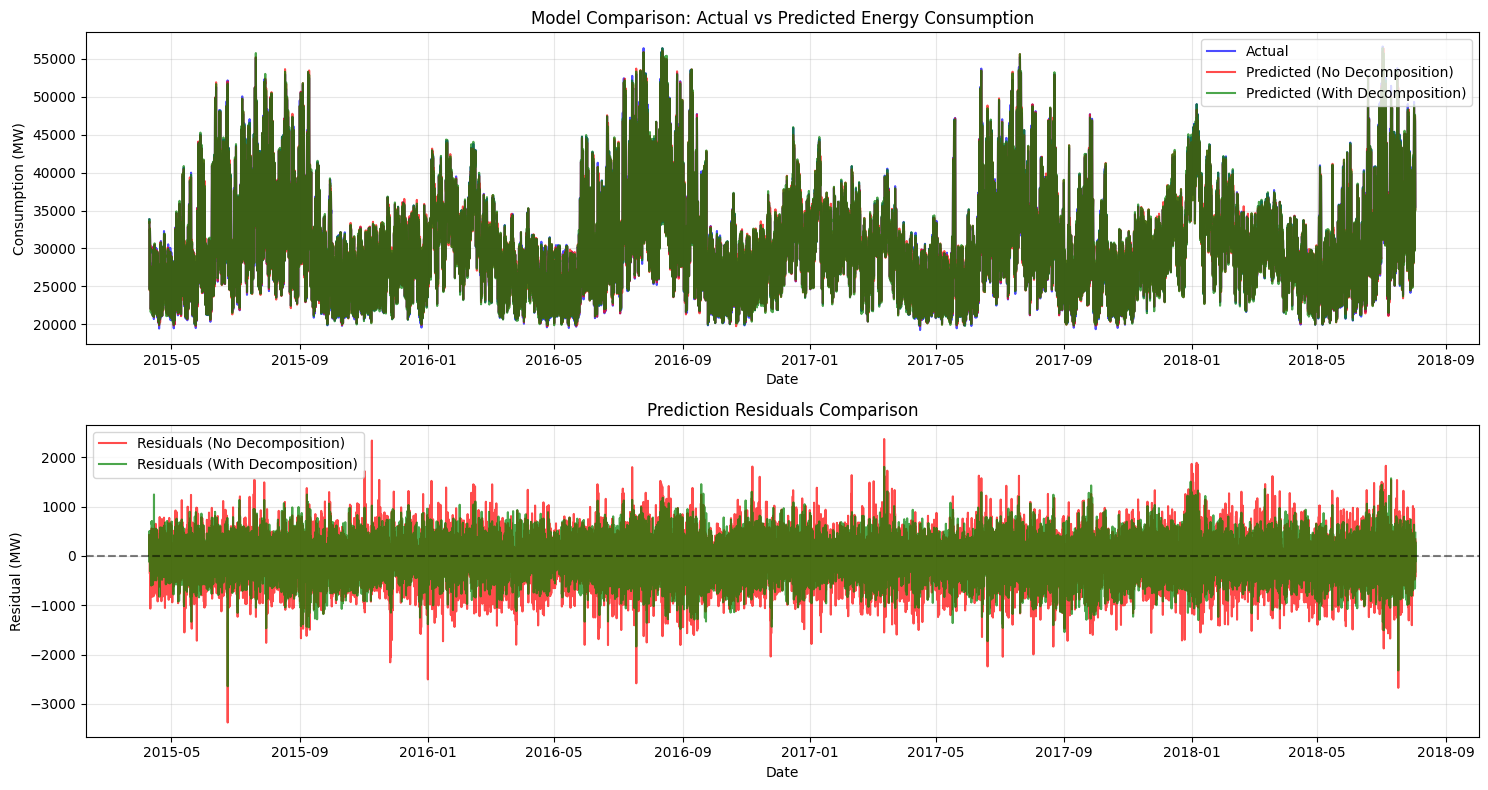

In [41]:
# Visualization comparing both predictions
plt.figure(figsize=(15, 8))

# Plot actual values
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_no_decomp, label='Predicted (No Decomposition)', color='red', alpha=0.7)
plt.plot(y_test.index, y_pred_with_decomp, label='Predicted (With Decomposition)', color='green', alpha=0.7)
plt.title('Model Comparison: Actual vs Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(2, 1, 2)
residuals_no_decomp = y_test - y_pred_no_decomp
residuals_with_decomp = y_test - y_pred_with_decomp
plt.plot(y_test.index, residuals_no_decomp, label='Residuals (No Decomposition)', color='red', alpha=0.7)
plt.plot(y_test.index, residuals_with_decomp, label='Residuals (With Decomposition)', color='green', alpha=0.7)
plt.title('Prediction Residuals Comparison')
plt.xlabel('Date')
plt.ylabel('Residual (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

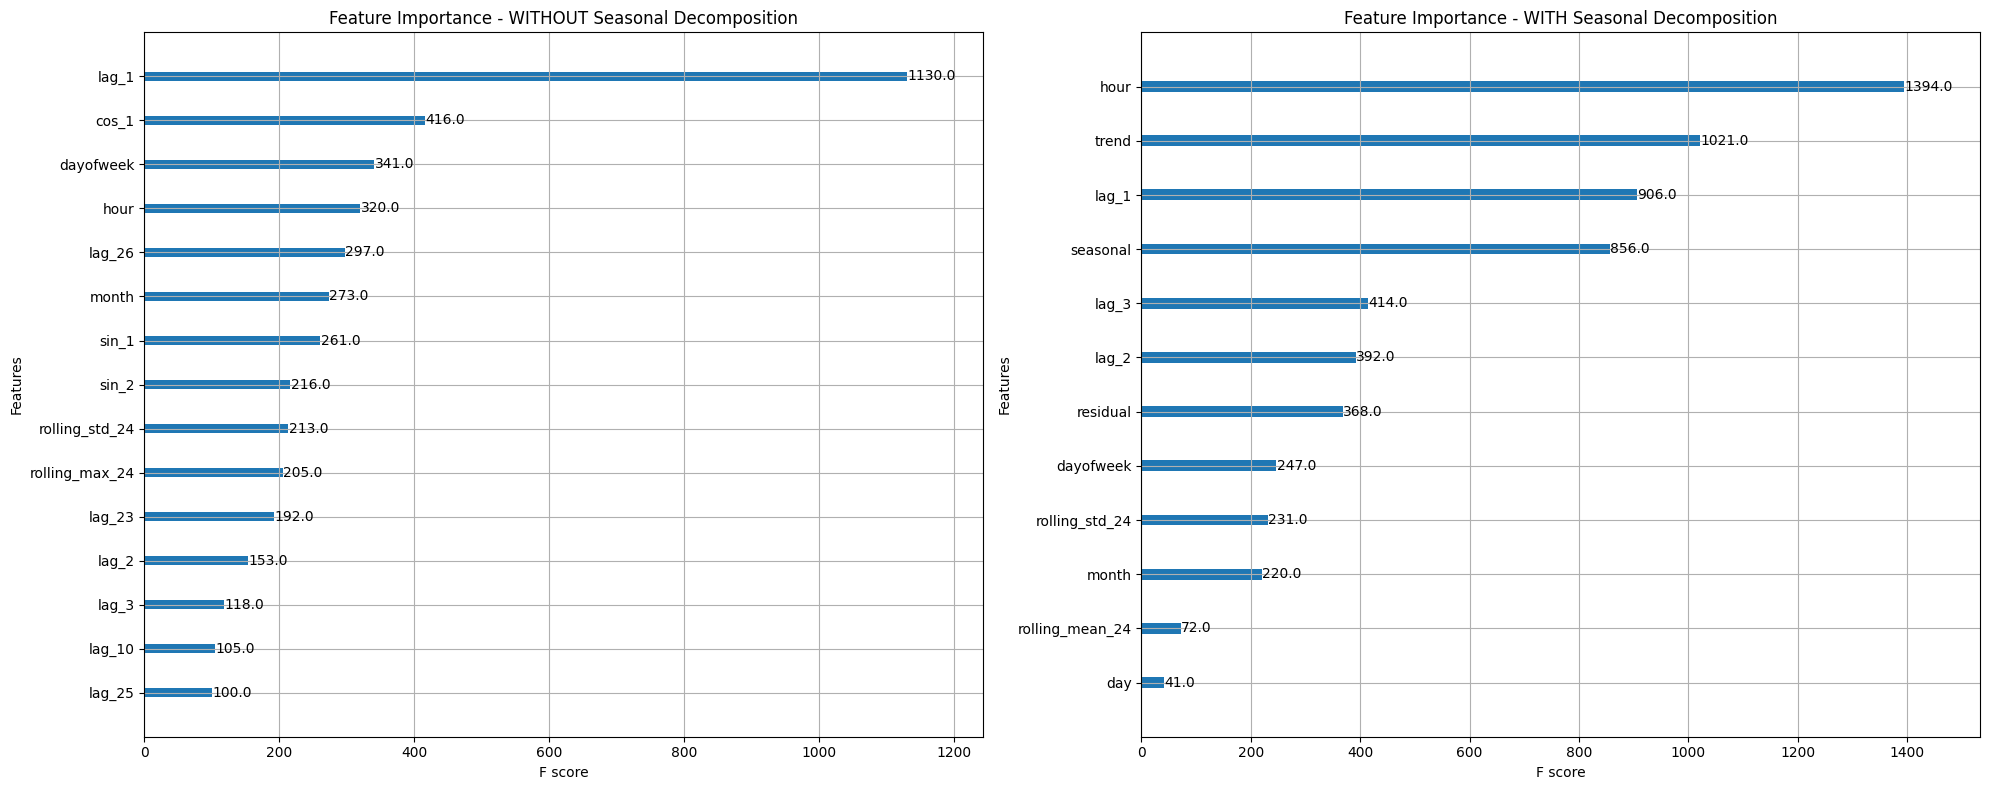

In [42]:
# Feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Without decomposition
xgb.plot_importance(model_no_decomp, ax=ax1, max_num_features=15)
ax1.set_title('Feature Importance - WITHOUT Seasonal Decomposition')

# With decomposition
xgb.plot_importance(model_with_decomp, ax=ax2, max_num_features=15)
ax2.set_title('Feature Importance - WITH Seasonal Decomposition')

plt.tight_layout()
plt.show()
